In [27]:
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
code_departement = "093"
compare_with_idf = True

# Imports & setup

In [29]:
import logging

import geopandas as gpd
import matplotlib.pyplot as plt

from potentiel_solaire.constants import DATA_FOLDER, CRS
from potentiel_solaire.sources.bd_topo import extract_bd_topo, get_topo_buildings_of_interest
from potentiel_solaire.aggregate import aggregate_solar_potential_by

logging.getLogger().setLevel("WARNING")

In [30]:
path_results = DATA_FOLDER / f"{code_departement}_pipeline_results.gpkg"

# Recupération des resultats intermédiaires

### Etablissements scolaires


In [31]:
schools_establishments = gpd.read_file(path_results, layer="schools_establishments")
nb_schools = schools_establishments.shape[0]
print(f"Nb d'établissements scolaires: {nb_schools}")

Nb d'établissements scolaires: 1130


### Zones d'éducations

In [32]:
educational_zones = gpd.read_file(path_results, layer="educational_zones")
nb_educational_zones = educational_zones.shape[0]
print("Nb de zones d'éducations: ", nb_educational_zones)

Nb de zones d'éducations:  1088


### Bâtiments

In [33]:
bd_topo_path = extract_bd_topo(code_departement=code_departement)
codes_commune = schools_establishments["code_commune"].unique()
communes = gpd.read_file(bd_topo_path, layer="commune").to_crs(CRS)
communes = communes[communes.code_insee.isin(codes_commune)]
geom_of_interest = communes.dissolve()[["geometry"]]
buildings = get_topo_buildings_of_interest(
    bd_topo_path=bd_topo_path,
    geom_of_interest=geom_of_interest,
    crs=CRS
)

/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(256)' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(30)' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'timestamp with time zone' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/io/file.py:497: UserWarning: More than one layer found in 'BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15.gpkg': 'troncon

### Rattachement des bâtiments scolaires

In [ ]:
schools_buildings = gpd.read_file(path_results, layer="schools_buildings")
nb_schools_buildings = schools_buildings.shape[0]
print(f"Nb de batiments rattachés à des écoles: {nb_schools_buildings}")
# v0: Nb de batiments rattachés à des écoles: 3731

Nb de batiments rattachés à des écoles: 3731


### Calcul du potentiel solaire

In [35]:
solar_potential_of_schools_buildings = gpd.read_file(path_results, layer="solar_potential_of_schools_buildings")

# Checks sur la qualité des données & calculs

In [ ]:
nb_schools_with_buildings = len(schools_buildings.identifiant_de_l_etablissement.unique())
print("Nb d'établissements scolaires avec des batiments: {} ({}%)".format(
    nb_schools_with_buildings,
    round(100 * nb_schools_with_buildings / nb_schools)
))
# V0: Nb d'établissements scolaires avec des batiments: 445 (39%)

Nb d'établissements scolaires avec des batiments: 445 (39%)


In [ ]:
missing_schools_establishments = schools_establishments.merge(
    schools_buildings.drop_duplicates(subset=["identifiant_de_l_etablissement"])[["identifiant_de_l_etablissement", "cleabs_zone"]],
    on="identifiant_de_l_etablissement",
    how="left"
)
missing_schools_establishments = missing_schools_establishments[missing_schools_establishments["cleabs_zone"].isna()]
nb_missing_schools_establishments = missing_schools_establishments.shape[0]
print("Nb d'établissements scolaires sans batiment: {} ({}%)".format(
    nb_missing_schools_establishments,
    round(100 * nb_missing_schools_establishments / nb_schools)
))

# V0: Nb d'établissements scolaires sans batiment: 685 (61%)

Nb d'établissements scolaires sans batiment: 685 (61%)


In [ ]:
missing_educational_zones = educational_zones.merge(
    schools_buildings.drop_duplicates(subset=["cleabs_zone"])[["cleabs_zone"]],
    left_on="cleabs",
    right_on="cleabs_zone",
    how="left"
)
missing_educational_zones = missing_educational_zones[missing_educational_zones["cleabs_zone"].isna()]
missing_educational_zones.drop(columns=["cleabs_zone"], inplace=True)

nb_missing_educational_zones = len(missing_educational_zones.cleabs.unique())
print("Nb de zones d'educations non rattachées à un établissement scolaire: {} ({}%)".format(
    nb_missing_educational_zones,
    round(100 * nb_missing_educational_zones / nb_educational_zones)
))

v0: Nb de zones d'educations non rattachées à un établissement scolaire: 643 (59%)

Nb de zones d'educations non rattachées à un établissement scolaire: 643 (59%)


In [ ]:
missing_buildings = gpd.sjoin(
        buildings,
        missing_educational_zones,
        how='inner',
        predicate='intersects',
        lsuffix='bat',
        rsuffix='zone'
    )
nb_missing_buildings = missing_buildings.shape[0]
print(f"Nb de batiments sur des zones non rattachées: {nb_missing_buildings}")

# v0: Nb de batiments sur des zones non rattachées: 2451

Nb de batiments sur des zones non rattachées: 2451


In [ ]:
buildings_affected_to_multiple_schools = solar_potential_of_schools_buildings[solar_potential_of_schools_buildings.duplicated(subset=["cleabs_bat"],keep=False)]
nb_buildings_affected_to_multiple_schools = buildings_affected_to_multiple_schools.shape[0]
print("Nb de batiments affectés en doubles: {} ({}%)".format(
    nb_buildings_affected_to_multiple_schools, 
    round(100 * nb_buildings_affected_to_multiple_schools / nb_schools_buildings)    
))

# V0: Nb de batiments affectés en doubles: 89 (2%)

Nb de batiments affectés en doubles: 89 (2%)


In [ ]:
school_buildings_only_in_educational_zones = gpd.overlay(
    solar_potential_of_schools_buildings,
    educational_zones[["geometry"]],
    how="intersection",
).to_crs(epsg=6933)

total_floor_area = solar_potential_of_schools_buildings["surface_totale_au_sol"].sum()
total_floor_area_only_in_educational_zones = school_buildings_only_in_educational_zones.area.sum()
area_not_in_educational_zones = total_floor_area - total_floor_area_only_in_educational_zones
print(f"{total_floor_area:,.0f} m² de surface au sol pour tous les batiments scolaires, dont {area_not_in_educational_zones:,.0f} m² ({100*area_not_in_educational_zones/total_floor_area:.0f}%) ne sont pas dans une zone d'education")
#V0: 1,671,571 m² de surface au sol pour tous les batiments scolaires, dont 198,644 m² (12%) ne sont pas dans une zone d'education

1,671,571 m² de surface au sol pour tous les batiments scolaires, dont 198,644 m² (12%) ne sont pas dans une zone d'education


In [42]:
results_by_school = aggregate_solar_potential_by(
    schools_establishments=schools_establishments,
    solar_potential_of_schools_buildings=solar_potential_of_schools_buildings,
    group_by = [
        "identifiant_de_l_etablissement",
        "nom_etablissement",
        "type_etablissement",
        "libelle_nature",
        "code_commune",
        "nom_commune",
        "code_departement",
        "libelle_departement",
        "code_region",
        "libelle_region",
    ]
)

array([[<Axes: title={'center': 'surface_utile'}>]], dtype=object)

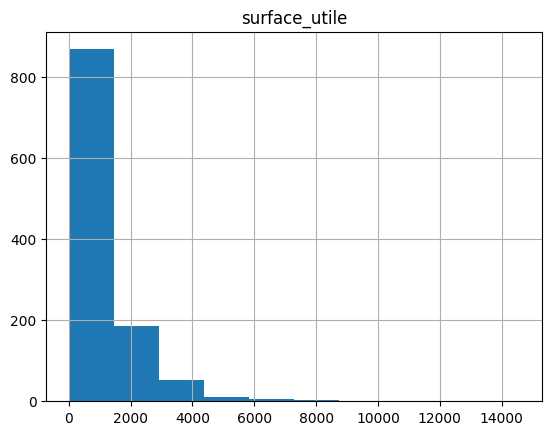

In [43]:
results_by_school.hist(column="surface_utile", bins=10)

array([[<Axes: title={'center': 'rayonnement_solaire'}>]], dtype=object)

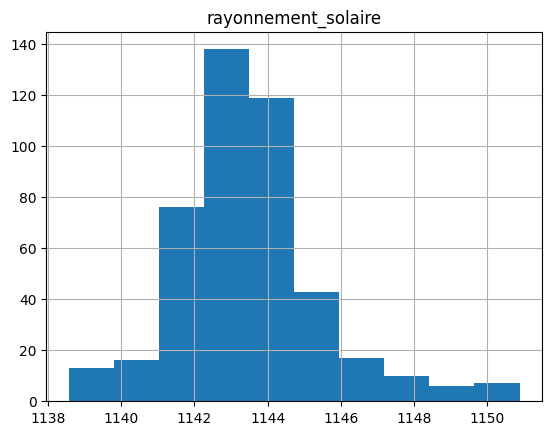

In [44]:
results_by_school.hist(column="rayonnement_solaire", bins=10)

array([[<Axes: title={'center': 'potentiel_solaire'}>]], dtype=object)

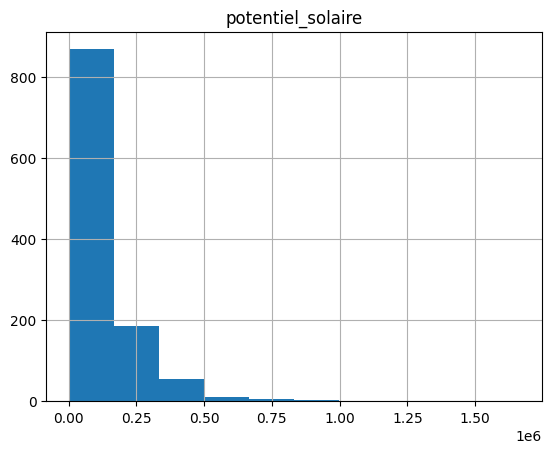

In [45]:
results_by_school.hist(column="potentiel_solaire", bins=10)

# Comparaison avec le potentiel solaire des toitures (IDF)

In [46]:
if compare_with_idf:
    # Audit des données sur Département 93
    GPKG = DATA_FOLDER / "potentiel-solaire.geojson"
    gspsdt_total = gpd.read_file(GPKG, mask=geom_of_interest)
    print(len(gspsdt_total),"batiments")
    gspsdt_total=  gspsdt_total.to_crs(4326)

286433 batiments


In [47]:
if compare_with_idf:
    batiments_a_auditer = solar_potential_of_schools_buildings.cleabs_bat.unique()
    gspsdt = gspsdt_total[gspsdt_total.id.isin(batiments_a_auditer)]

    gspsdt = gspsdt[["id","st_areashape","surf_util","moyenne2","production"]]
    comparaison = gspsdt.merge(solar_potential_of_schools_buildings[["cleabs_bat","surface_totale_au_sol","surface_utile","rayonnement_solaire","potentiel_solaire"]],\
             left_on='id', right_on='cleabs_bat', how="inner")
    
    total_ecole         = comparaison.production.sum()
    total_ecole_calcule = comparaison.potentiel_solaire.sum()
    print("# Verification des potentiels pour:",code_departement,"\n")
    print("* Verification effectuée sur:",len(comparaison),"batiments.")
    print("* BDD Potentiel solaire\t",int(total_ecole),"kWh/an")
    print("* Estimation ordre 0\t",int(total_ecole_calcule),"kWh/an")
    print("* Tentative accuracy\t",int((total_ecole_calcule-total_ecole)/total_ecole*100),"%")

# Verification des potentiels pour: 093 

* Verification effectuée sur: 2612 batiments.
* BDD Potentiel solaire	 73328015 kWh/an
* Estimation ordre 0	 85376700 kWh/an
* Tentative accuracy	 16 %


In [48]:
if compare_with_idf:
    lack = len(batiments_a_auditer)-len(gspsdt)
    print("* There are",len(batiments_a_auditer),"batiments in",code_departement)
    print("* There are",len(gspsdt),"batiments in the solar potential database for these buildings")
    print("* Coverage of that DB (%):",100*len(gspsdt)/len(batiments_a_auditer))

* There are 3686 batiments in 093
* There are 2574 batiments in the solar potential database for these buildings
* Coverage of that DB (%): 69.83179598480739


In [49]:
def scatter_plot(df, column_x, column_y):
    x = df[column_x]
    y = df[column_y]
    minimum = min(df[column_x].min(), df[column_y].min())
    maximum = max(df[column_x].max(), df[column_y].max())
    plt.scatter(x, y)
    plt.plot([minimum, maximum], [minimum, maximum], color='red', linestyle='--')
    plt.title(f"Compare {column_x} with {column_y}")
    plt.xlabel(f"{column_x}")
    plt.ylabel(f"{column_y}")
    plt.show()

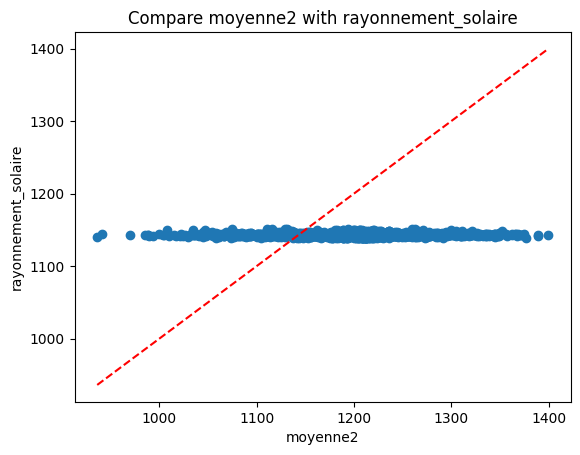

In [50]:
if compare_with_idf:
    scatter_plot(comparaison, "moyenne2", "rayonnement_solaire")

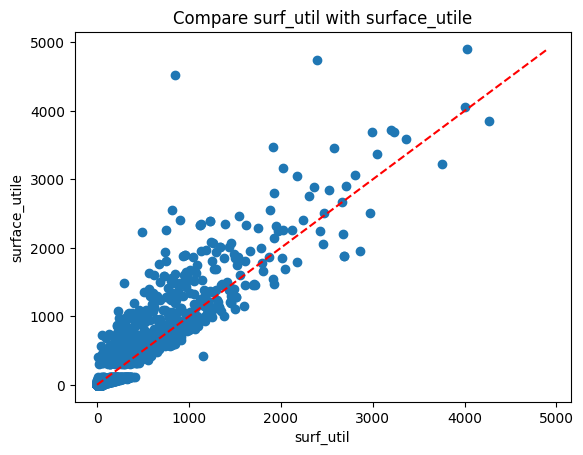

In [51]:
if compare_with_idf:
    scatter_plot(comparaison, "surf_util", "surface_utile")

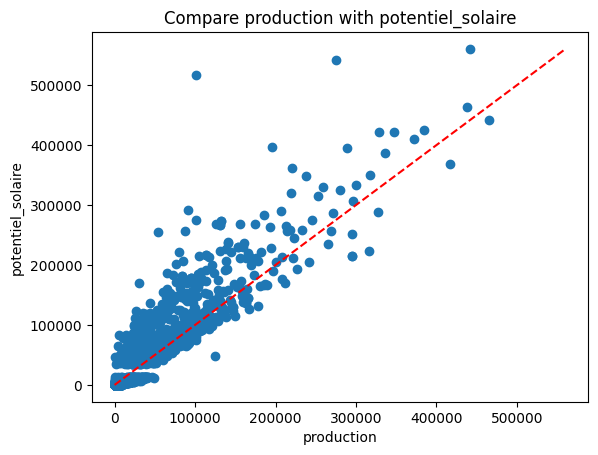

In [52]:
if compare_with_idf:
    scatter_plot(comparaison, "production", "potentiel_solaire")